In [1]:
%matplotlib inline

import pandas as pd
import numpy as np
import re

## Plotting tools, matplotlib and seaborn
import matplotlib.pyplot as plt
import seaborn as sns

## Imputation strategies from Kaggle - Intermediate machine learning course
## https://www.kaggle.com/alexisbcook/pipelines
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import LabelEncoder

In [2]:
## Read train and test dataset
train = pd.read_csv('train.csv')
test = pd.read_csv('test.csv')

## Get information of the data count and type
# train.info()

Text(0, 0.5, 'Count (females)')

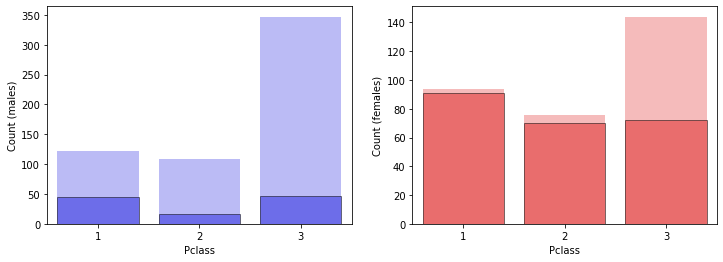

In [3]:
## Describe numerical data

# train.info()  # Describe columns, entries, type of data
# train.describe() # Descriptive first order statistics
# train.nunique() # Describe unique values?
# train.isnull().sum() # Number of missing values

# Looking for the unique values for each feature 
# train["Age"].value_counts()
# train["SibSp"].value_counts()
# train["Parch"].value_counts()
# train["Sex"].value_counts()

train["Title"] = (train['Name'].str.split(',').apply(lambda x : x[1])).str.split('.').apply(lambda x : x[0])
train['AgeRange'] = train.apply(lambda row:np.floor(row['Age']/10)*10, axis=1)
# train = train[train.Age <= 335]
# train[(train.Sex == 'female') & (train.Survived == 1)]

# sns.scatterplot(x="Age", y="Pclass", hue="Survived", data=train[(train.Sex == 'male')])
# sns.scatterplot(x="Age", y="Title", hue="Survived", data=train[(train.Sex == 'female')])

# sns.distplot(train.Age[train.Sex =='female'].dropna())
# train["Title"].value_counts()
# sns.distplot(train.Age[(train.Survived == 1) & (train.Sex == 'female') & (train.Title == 'Miss')].dropna())


# g = sns.FacetGrid(train[(train.Sex=='male')], row='Survived', col='Pclass')
# g.map(sns.distplot, "Age")
# g.set(xlim=(0, 40))
# plt.show()

# h = sns.heatmap(train.corr(), annot=True, fmt=".2f")
# h.set(xlim=(0, None))
# plt.show()


# ax = sns.catplot(x='Pclass',kind='count',data=train[train.Sex=='female'])
# f, axes = plt.subplots(1, 2, figsize = (12,4))
# g = sns.catplot(x='Pclass',kind='count', hue='Sex',data=train, alpha =0.25)
# g = sns.catplot(x='Pclass',kind='count', hue='Sex',data=train[(train.Survived == 1)], alpha =0.75)
# ax.fig.autofmt_xdate()
# hatches = ['-', '+', 'x', '\\', '*', 'o']
# sex_palette = ['blue', 'red']
# sns.set_palette(sex_palette)

# There is a serious disadvantage, the data being plotted is of the order male, female, female and male. 
# Therefore the default comparison comes between total males and total surviving females.
# Hence adopted the count plot categorizing the male and female survival rates separately across the classes
# ax = sns.countplot(x="Pclass", hue="Sex", data=train, alpha= 0.3)
# ax = sns.countplot(x="Pclass", hue="Sex", data=train[(train.Survived==1)], alpha= 0.5, edgecolor=(0,0,0))

f, axes = plt.subplots(1, 2, figsize = (12,4))
g = sns.countplot(x="Pclass", data=train[(train.Sex=='male')], alpha= 0.3, color='blue', ax=axes[0])
g = sns.countplot(x="Pclass", data=train[(train.Survived==1) & (train.Sex=='male')], alpha= 0.5, edgecolor=(0,0,0), color='blue', ax=axes[0])
g.set_ylabel("Count (males)")
h = sns.countplot(x="Pclass", data=train[(train.Sex=='female')], alpha= 0.3, color='red', ax=axes[1])
h = sns.countplot(x="Pclass", data=train[(train.Survived==1) & (train.Sex=='female')], alpha= 0.5, edgecolor=(0,0,0), color='red', ax=axes[1])
h.set_ylabel("Count (females)")

In [4]:
# Male survival rates
# train[(train.Sex=='male') & (train.Survived==1)].groupby('Pclass').PassengerId.count()/train[(train.Sex=='male')].groupby('Pclass').PassengerId.count()

In [5]:
# Female survival rates
# train[(train.Sex=='female') & (train.Survived==1)].groupby('Pclass').PassengerId.count()/train[(train.Sex=='female')].groupby('Pclass').PassengerId.count()

#### Explanation
In the figure, blue represents males and orange represent females, the light shades represent the total people in each class and dark shade with black edges to denote survival. From figure and the previous code blocks and the figure, we can see the percentage of people surviving decreases from first to third class. Also  based on sex, females have a higher percentage of survival.

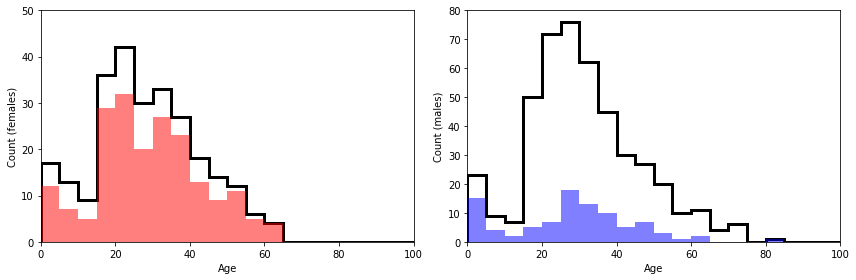

In [6]:
f, axes = plt.subplots(1, 2, figsize = (12,4))
age_range = range(0,120,5)

# Female age distribution count plot
g = sns.distplot(train.Age[train.Sex =='female'].dropna(),bins=age_range, kde = False, hist_kws={"histtype": "step", "linewidth": 3, "alpha": 1, "color": "k"},ax=axes[0])
g =sns.distplot(train.Age[(train.Sex =='female') & (train.Survived==1)].dropna(),bins=age_range,kde=False, hist_kws={"alpha": 0.5},ax=axes[0], color='red')
g.set_ylabel("Count (females)")
g.set_xlim([0,100])
g.set_ylim([0,50])

# Male age distribution count plot
h = sns.distplot(train.Age[train.Sex =='male'].dropna(),bins=age_range, kde = False, hist_kws={"histtype": "step", "linewidth": 3, "alpha": 1, "color": "k"},ax=axes[1])
h = sns.distplot(train.Age[(train.Sex =='male') & (train.Survived==1)].dropna(),bins=age_range, kde=False, hist_kws={"alpha": 0.5}, ax=axes[1], color ='blue')
h.set_ylabel("Count (males)")
h.set_xlim([0,100])
h.set_ylim([0,80])
f.tight_layout()

In [7]:
### Rationale is to impute age data based on the title of the person

# sns.catplot(x='AgeRange',kind='count', hue='Title',data=train[train.Sex=='male'], alpha =1.0)
# sns.catplot(x='AgeRange',kind='count', hue='Title',data=train[train.Sex=='female'], alpha =1.0)

# Impute_Age = train.groupby(['Title']).Age.median()
# Impute_Age = Impute_Age.to_dict()
# train.Age[train.Title==' Mr'] = train.Age[train.Title==' Mr'].fillna(train.Title.map(Impute_Age))

# train.Age.isnull().groupby(train.Title).sum()
# train.SibSp.groupby(train.AgeRange).sum()
# train.Parch.groupby(train.AgeRange).sum()

# train.Age.isnull().sum()

# train[train.Survived == 1].groupby(train.Title).PassengerId.count()
# train[train.Survived == 0].groupby(train.Title).PassengerId.count()

# train[train.Survived == 1].groupby(train.AgeRange).PassengerId.count()
# train[train.Survived == 0].groupby(train.AgeRange).PassengerId.count()

In [8]:
### Shows how much data is missing from features, it also shows the feature instead of train.describe function
# train.isnull().sum() 

# Search for data
# train[train['Embarked'].str.contains('Q')]
# train[train.isna().any(axis=1)]
# train_x["Embarked"].value_counts()
# name.value_counts()

In [9]:
# Check if the test data has same missing features, the imputation strategy is based on the previous and current output
# test.isnull().sum()

In [10]:
train_x = train.drop(columns='Survived')
train_y = train['Survived']

In [11]:
train_x.columns[train_x.isnull().any()].tolist()

['Age', 'Cabin', 'Embarked', 'AgeRange']

The following part of the code is to evaluate various imputation strategies used in machine learning

In [12]:
impute_column = [col for col in train_x.columns if train_x[col].isnull().any()]
numerical_cols = [cname for cname in train_x.columns if train_x[cname].dtype in ['int64', 'float64']]
# train_x = dataImputationDropColumn(train_x,impute_column)
categorical_cols = [cname for cname in train_x.columns if train_x[cname].dtype in ['object']]

In [13]:
# Preprocessing for numerical data
# Strategy : mean, median, most_frequent(string, numeric), constant (string, numeric)
numerical_transformer = SimpleImputer(strategy='median')

# Preprocessing for categorical data
LE = LabelEncoder()

In [14]:
train_x.isnull().sum()

PassengerId      0
Pclass           0
Name             0
Sex              0
Age            177
SibSp            0
Parch            0
Ticket           0
Fare             0
Cabin          687
Embarked         2
Title            0
AgeRange       177
dtype: int64

In [15]:
# train_x["Name"] = (train['Name'].str.split(',').apply(lambda x : x[1])).str.split('.').apply(lambda x : x[0])
train_x["Ticket"] = train["Ticket"].str.extract('(\d+)')
train_x.Ticket = train_x.Ticket.astype('float')
train_x.Age = train_x.Age.fillna(value=train_x.Age.mean())
train_x.Ticket = train_x.Ticket.fillna(value=train_x.Ticket.median())
train_x.Embarked = train_x.Embarked.fillna(value=train_x.Embarked.mode()[0])

train_x.Title = LE.fit_transform(train_x.Title)
# train_x.Name = LE.fit_transform(train_x.Name)
train_x.Sex = LE.fit_transform(train_x.Sex)
train_x.Embarked = LE.fit_transform(train_x.Embarked)

## Drop the unnecessary columns, Cabin has more than 25% of data missing and Age Range has infact decreased the performance
if "Cabin" in train_x :
    train_x = train_x.drop(columns = ["Cabin"])
if "AgeRange" in train_x :
    train_x = train_x.drop(columns = ["AgeRange"])
if "Title" in train_x :
    train_x = train_x.drop(columns = ["Name"])



In [16]:
# Check if any rows are having nan
# train_x.isnull().sum()

In [17]:
from sklearn.metrics import accuracy_score
from sklearn.model_selection import train_test_split

X_train, X_valid, y_train, y_valid = train_test_split(train_x, train_y, train_size=0.8, test_size=0.2,
                                                      random_state=0)
def score_model(model, X_t=X_train, X_v=X_valid, y_t=y_train, y_v=y_valid):
    model.fit(X_t, y_t)
    preds = model.predict(X_v)
#     display(preds)
#     pred_cutOFF = 0.50
#     preds[preds >= pred_cutOFF] = 1
#     preds[preds < pred_cutOFF] = 0
    return accuracy_score(y_v, preds)

In [18]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import RandomTreesEmbedding
from sklearn.ensemble import GradientBoostingClassifier
from sklearn import svm
from xgboost import XGBClassifier
model_1 =  RandomForestClassifier(n_estimators=250, max_depth=50, random_state=0)
model_2 = RandomForestClassifier(n_estimators=10, max_depth=50, random_state=0)
model_3 = XGBClassifier(base_score=0.5, colsample_bylevel=1, colsample_bytree=1, gamma=0, learning_rate=0.01, max_delta_step=0, max_depth=500, 
                        min_child_weight=1, missing=None, n_estimators=1000, nthread=-1, objective='binary:logistic', reg_alpha=0, reg_lambda=1,
                        scale_pos_weight=1, seed=0, silent=True, subsample=1)
model_4 = GradientBoostingClassifier(loss='exponential', learning_rate=0.1, n_estimators=250, max_depth=4, tol=1e-6)

model_5 = svm.SVC(gamma=0.020, C=0.0001)

In [19]:
from sklearn.ensemble import AdaBoostClassifier
model_7 = AdaBoostClassifier(n_estimators=1000,learning_rate=0.1)
score_model(model_7)

0.8044692737430168

In [20]:
from sklearn.neural_network import MLPClassifier
model_6 = MLPClassifier(activation='relu', solver='lbfgs', learning_rate='invscaling', max_iter = 6000)
score_model(model_6)

0.6536312849162011

In [21]:
from sklearn.neighbors import KNeighborsClassifier
model_8 = KNeighborsClassifier(32)
score_model(model_8)

0.7430167597765364

In [22]:
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
model_9 = LinearDiscriminantAnalysis()
score_model(model_9)

0.776536312849162

In [23]:
from sklearn.discriminant_analysis import QuadraticDiscriminantAnalysis
model_10=QuadraticDiscriminantAnalysis()
score_model(model_10)

0.8100558659217877

In [24]:
score_model(model_2)

0.8324022346368715

In [25]:
score_model(model_3)

0.8659217877094972

In [26]:
score_model(model_4)

0.8547486033519553